# Chilean pig and bird data

This notebook examines data from the Register of Livestock Establishments ([Registro de Establecimientos Pecuarios](https://https://www.sag.gob.cl/ambitos-de-accion/registro-de-establecimientos-pecuarios)) maintained by the Agriculture and Livestock Service of the Chilean Agricultural Ministry. According to the web page, "The RUP corresponds to the mandatory identification of each livestock establishment in the country." The data were obtained (with some difficulty) under Chilean transparency laws by C. Leibsch, a Chilean researcher and animal advocate.

There is one spreadsheet for "pigs" and another for "birds". The spreadsheets don't contain any further information about animal type or life stage, but they do contain farm coordinates and animal numbers, along with some other geographical information (such as the Chilean region each establishment is in).

In [ ]:
try:
  import unidecode
except ModuleNotFoundError:
  !pip install pyogrio==0.7.2 geopandas==0.14.3 unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.14.4
    Uninstalling geopandas-0.14.4:
      Successfully uninstalled geopandas-0.14.4


In [ ]:
%load_ext autoreload
%autoreload 2

import sys, os
from IPython.core.magic import register_cell_magic
from glob import glob
import numpy as np
from unidecode import unidecode
from google.colab import drive
import ee
import geemap.foliumap as geemap
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import pyarrow

gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

In [ ]:
ee.Authenticate()
ee.Initialize(project="215656163750")
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils, explore

@register_cell_magic
def skip(line, cell):
    return

path = "/content/drive/MyDrive/CAFO_data/"

Mounted at /content/drive


## Basic farm information

Unlike the DMV poultry and NC pigs datasets, the Chile data are associated with numbers of animals per farm. We can therefore investigate the distribution of that quantity, and look at the numbers of animals in each farm size bin. This will give an idea, at least for this one country, of the fraction of animals that come from large vs small farms.

Start by reading the data and display a couple of rows, just to show what we have to work with.

In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/CAFO_data/Chile/RUP-porcinos-2022 (1).xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/CAFO_data/Chile/RUP-aves-2022 (2) (3).xlsx')

In [ ]:
display(df1.sample(1))
display(df2.sample(1))

,REGION,PROVINCIA,COMUNA,OFICINA,RUP,RUP_NOMBRE,DIRECCION_ESTABLECIMIENTO,LOCALIDAD,COORDENADA_X,COORDENADA_Y,HUSO,CANTIDAD
31916,DE LOS LAGOS,LLANQUIHUE,MAULLIN,OFICINA PTO. MONTT,10.1.08.0472,POLEBON,PUELPUN,MAULLIN,629305.0,5398923.0,18.0,3


,REGION,PROVINCIA,COMUNA,OFICINA,RUP,RUP_NOMBRE,DIRECCION_ESTABLECIMIENTO,LOCALIDAD,COORDENADA_X,COORDENADA_Y,HUSO,CANTIDAD
42657,DE LOS RIOS,VALDIVIA,PAILLACO,OFICINA PAILLACO,14.1.07.1249,HIJUELA 4 FUNDO EL CRISTO,PICHIRROPULLI,PAILLACO - PICHIRROPULLI,676762.0,5553000.0,18.0,22


We now define the animal numbers we will later be interested in (the 'CANTIDAD' column in the spreadsheets). We want to exclude very small farms to keep the computations manageable. The next few cells and plots won't actually exclude farms outside this size range, but they will give some information about numbers of farms inside and outside it.

It can be useful to temporarily set different size ranges in order to visually examine farms in a certain size range on the map.

In [ ]:
pig_range = (100, 1e7)
bird_range = (1000, 1e7)

Then we print some information about the data. We can see that:


1.   There are many farms with CANTIDAD=0. It is not clear why this is, or how many farms these animals might actually have.
2.   There are some farms with very large animal numbers (e.g. ~50000 pigs). If we visually inspect those farms on a map, we can see that they are real and are large CAFOs. It is not clear that they are larger than other CAFOs, though.

Overall, it seems that the animal numbers in this dataset are useful but should be used with some caution.

In [ ]:
explore.describe_data(df1, 'pigs', pig_range, 'COORDENADA_X', 'CANTIDAD')
explore.describe_data(df2, 'birds', bird_range, 'COORDENADA_X', 'CANTIDAD')

There are 44444 entries in the pigs spreadsheet
40253 farms have valid coordinates
29522 farms report 0 pigs
The largest farm reports 53133 pigs
There are 14706 farms with 0 < pigs < 100
  - They account for 116374 pigs
There are 211 farms with  100 < pigs < 10000000.0
  - They account for 2535881 pigs 

There are 45037 entries in the birds spreadsheet
40831 farms have valid coordinates
3147 farms report 0 birds
The largest farm reports 5500000 birds
There are 41243 farms with 0 < birds < 1000
  - They account for 1274458 birds
There are 630 farms with  1000 < birds < 10000000.0
  - They account for 65333716 birds 



The next cell creates histograms of number of animals per farm and cumulative animal numbers. The histograms contain farms of all sizes, not just in the range we defined a few cells ago (except those with CANTIDAD=0). Taken at face value (ignoring the reservations mentioned above), these plots indicate that although most farms are small, most animals are on the largest farms.




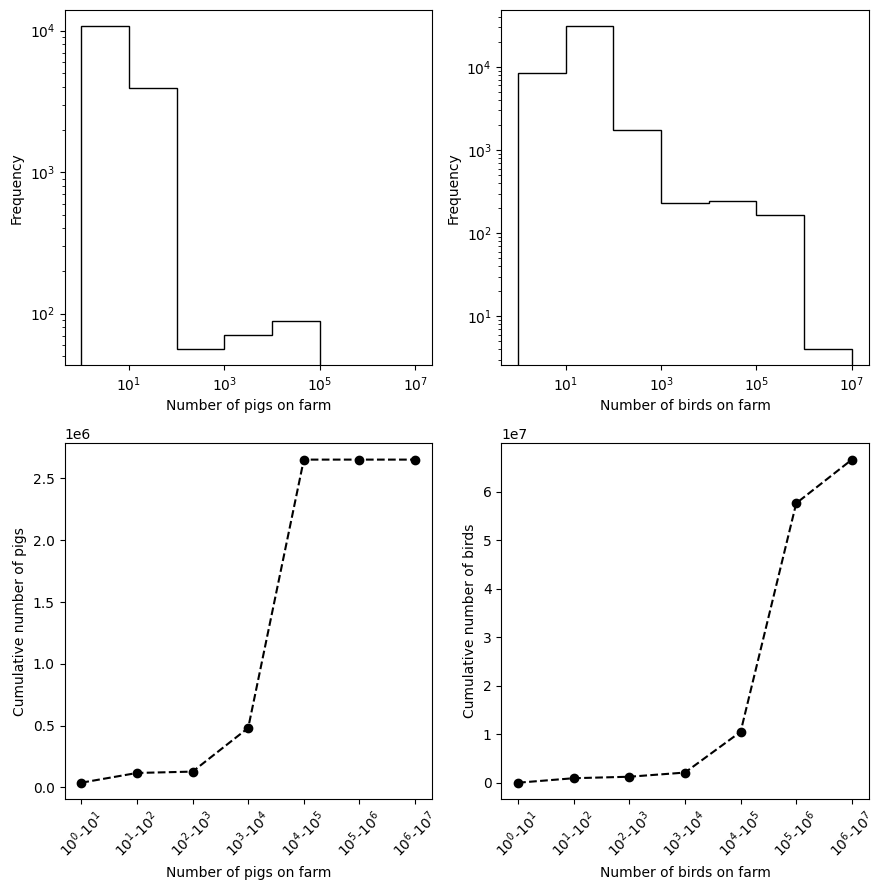

In [ ]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))

explore.histo(df1, ax1, ax3, 'pigs', 'CANTIDAD')
explore.histo(df2, ax2, ax4, 'birds', 'CANTIDAD')
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Chile_farm_histos.png')

We will now drop farms with animal numbers outside the ranges of interest defined above, and also convert coordinates and tidy up the data a bit.

In [ ]:
# The coords in the original spreadsheets are Eastings and Northings;
# need to convert to Long and Lat

def convertCoords(row):
    crs_from = pyproj.CRS("EPSG:32719")
    crs_to = pyproj.CRS("EPSG:4326")
    lat, lon = pyproj.Transformer.from_crs(crs_from, crs_to).\
                 transform(row['COORDENADA_X'], row['COORDENADA_Y'])
    return pd.Series({'Longitude':lon, 'Latitude':lat})

In [ ]:
def refine_data(df, animal_type, size_range):

  df = df[(~df['COORDENADA_X'].isnull()) | (~df['COORDENADA_Y'].isnull())]

  df = df[(df['CANTIDAD'] > size_range[0]) & (df['CANTIDAD'] < size_range[1])]
  df.loc[:, "Number of animals"] = df.loc[:, "CANTIDAD"]

  df.loc[:, "Farm type"] = animal_type

  df[['Longitude', 'Latitude']] = df.apply(convertCoords, axis=1)
  df = df.sort_values(by='Latitude', ascending=False).reset_index(drop=True)

  gdf = gpd.GeoDataFrame(df, geometry=\
                       gpd.points_from_xy(df["Longitude"], df["Latitude"],\
                                          crs="EPSG:4326"))

  gdf = gdf.drop(columns=["Latitude", "Longitude", "COORDENADA_X", "COORDENADA_Y",\
                          "DIRECCION_ESTABLECIMIENTO", "LOCALIDAD", "CANTIDAD",\
                          "REGION", "PROVINCIA", "COMUNA", 'OFICINA', 'RUP',\
                          'RUP_NOMBRE', 'HUSO'])


  return gdf

In [ ]:
pigs = refine_data(df1, 'Pig', pig_range)
birds = refine_data(df2, 'Poultry', bird_range)

all_farms = pd.concat([pigs, birds]).reset_index(drop=True)
print(f"At this point there are {len(all_farms)} farms")
print(f" -- {len(pigs)} pig farms")
print(f" -- {len(birds)} poultry farms")

At this point there are 832 farms
 -- 206 pig farms
 -- 626 poultry farms


## Characteristics of farm buildings/animal housing: data preparation

It would now be interesting to examine the characteristics of buildings associated with the pig and bird farms in the size range of interest. We can do that by associating buildings in the global building footprint database with the Chilean farm coordinates. It's not feasible to do that for all of Chile, though. Instead, we will identify the 'comunas' that contain most of the farms, and restrict the building database to only those areas. (Chile is divided into regions that are subdivided into provincias and then comunas.)

In [ ]:
comunas = gpd.read_file(\
            '/content/drive/MyDrive/CAFO_data/Chile/shapefiles/chl_admbnda_adm3_bcn_20211008.shp'\
                          )
comunas.crs="EPSG:4326"
comunas = comunas[['ADM3_ES', 'ADM2_ES', 'geometry']].rename(\
                                                      columns={"ADM3_ES": "Comuna",\
                                                               "ADM2_ES": "Provincia"})
print(f"There are {len(comunas)} Comunas in Chile")

There are 345 Comunas in Chile


In [ ]:
# Create a df containing just the comunas that contain farms, and just the farms
# that have coords within real comunas (some farms have coords outside the country)

# Find intersection of comunas and farms, retaining geometry of the parent farm
all_farms.loc[:, 'temp geom'] = all_farms.loc[:, 'geometry']
joined = comunas.sjoin(all_farms, how='inner', predicate='intersects')

# Create df of comunas that contain farms
comunas_w_farms = joined[~joined.index.duplicated(keep='first')]
comunas_w_farms = comunas_w_farms[comunas.columns]
print(f"{len(comunas_w_farms)} Comunas contain farms in the specified size range")

# Create a df in which all these comunas are represented by a single multipolygon
single_geom = comunas_w_farms.drop(columns=["Comuna", "Provincia"]).dissolve(by=None)

# Create df of farms with coords within Chilean comunas
chile_farms = joined[all_farms.columns].drop(columns=['geometry'])\
              .set_geometry('temp geom').rename(columns={"temp geom": "geometry"})

print(f"There are {len(chile_farms)} farms with coords within Chilean comunas")
print(f" -- {len(chile_farms[chile_farms['Farm type'] == 'Pig'])} pig farms")
print(f" -- {len(chile_farms[chile_farms['Farm type'] == 'Poultry'])} poultry farms")

105 Comunas contain farms in the specified size range
There are 736 farms with coords within Chilean comunas
 -- 172 pig farms
 -- 564 poultry farms


The top 25 Comuna account for 524/736 farms (71%)


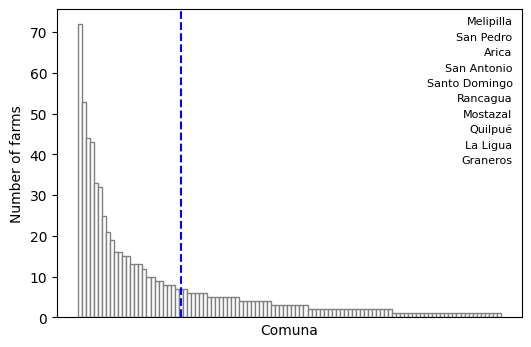

In [ ]:
# Plot the distribution of farms by comuna

_, ax = plt.subplots(1, 1, figsize=(6, 4))
explore.farms_per_region(joined, ax, 25, 'Comuna')
plt.savefig('/content/drive/MyDrive/CAFO_data/Analysis/Chile_farms_per_comuna.png')

Get the ancillary data - shapefiles of the Chilean regions, and building footprint data - then identify the buildings that are associated with farms. Then, make a map that shows those buildings, and also save the buildings to a geojson file for future use. Some of these steps take quite a long time to run, so the time-consuming ones are commented out in the next 3 cells. Uncomment the relevant lines to see the buildings on the map and/or recreate the saved files.

In [ ]:
min_building_size = 200

In [ ]:
%%skip
buildings_fc = (
      ee.FeatureCollection(f"projects/sat-io/open-datasets/VIDA_COMBINED/CHL")
      .filter(ee.Filter.gt('area_in_meters', min_building_size))
)

utils.write_to_file(buildings_fc, f"buildings_{min_building_size}_sq_m", 'Chile')
utils.ee_task_status()

In [ ]:
buildings = gpd.read_file(\
            f"/content/drive/MyDrive/CAFO_data/Chile/buildings_{min_building_size}_sq_m.geojson")
buildings.rename(columns={"area_in_meters": "Area (sq m)"}, inplace=True)
print(f"There are {len(buildings)} buildings > {min_building_size} sq m in Chile")

There are 879359 buildings > 200 sq m in Chile


In [ ]:
# Filter the buildings dataset to just the Comunas that contain registered farms

farm_comuna_bldgs = buildings.sjoin(single_geom, how='inner', predicate='within')
farm_comuna_bldgs = farm_comuna_bldgs.filter(["Area (sq m)", "geometry"])
print(f"There are {len(farm_comuna_bldgs)} buildings > {min_building_size} sq m in\
 the comunas with registered farms")

There are 363378 buildings > 200 sq m in the comunas with registered farms


In [ ]:
# Part of Chile is in UTM zone 18S, part is in 19S. We would need to use
# different projected CRSs for farms in different UTM zones, so we should check
# whether we need to do anything about that.

if chile_farms['geometry'].x.min() > -72 and chile_farms['geometry'].x.max() < -66:
  print("All farms are within UTM 19S, OK to proceed")
else:
  print("One or more farms are outside UTM 19S. Need to use multiple CRSs when\
  joining farms and buildings. Code needs to be updated.")


All farms are within UTM 19S, OK to proceed


In [ ]:
# Find all the buildings that are within <farm_dist> m of a
# farm, and those that are more than <not_farm_dist> away

crs = "EPSG:20049"
farm_dist = 150
not_farm_dist = 1000
farm_buildings, other_buildings = explore.join_farms_and_buildings(all_farms,\
                                                                  farm_comuna_bldgs,\
                                                                  farm_dist,\
                                                                  not_farm_dist,\
                                                                  crs)

print(f"There are {len(farm_buildings)} buildings within {farm_dist} m of farm coords ")
print(f"There are {len(other_buildings)} buildings >{not_farm_dist} m from\
 farm coords (either type) ")

There are 5303 buildings within 150 m of farm coords 
There are 336689 buildings >1000 m from farm coords (either type) 


In [ ]:
new_total = 0
for farm_type in ["Pig", "Poultry"]:
  n = len(chile_farms[chile_farms["Farm type"] == farm_type])
  print(f"Started with {n} farms of type {farm_type}")

  n = len(farm_buildings[farm_buildings["Farm type"] == farm_type].\
             groupby(by="Parent coords"))
  print(f" -- {n} are associated with buildings > {min_building_size} sq m")
  new_total += n

print(f"There is now a total of {new_total} farms")

Started with 172 farms of type Pig
 -- 163 are associated with buildings > 200 sq m
Started with 564 farms of type Poultry
 -- 496 are associated with buildings > 200 sq m
There is now a total of 659 farms


## Pig and poultry building characteristics

In [ ]:
# Calculate the lengths and aspect ratios of those buildings

farm_buildings = explore.get_dimensions(farm_buildings, crs=crs)

In [ ]:
# As we did for the NC pigs data (USA), we'll drop all but the largest building
# per farm

max_farm_bldgs = farm_buildings.sort_values('Area (sq m)', ascending=False)\
                              .drop_duplicates(['Parent coords'])
print(f"{len(farm_buildings)} buildings --> {len(max_farm_bldgs)} buildings")

5303 buildings --> 658 buildings


In [ ]:
# Obtain comparison data (Delmarva poultry and NC pigs; see the exploreUSAData
# notebook)

dmv_data = pd.read_pickle("/content/drive/MyDrive/CAFO_data/forTraining/interim_files/DMV_poultry_bldgs.pkl")
nc_data = pd.read_pickle("/content/drive/MyDrive/CAFO_data/forTraining/interim_files/NC_pigs_bldgs.pkl")

Pig farms 



,Area (sq m),Length (m),Aspect ratio
Min,201.206696,16.540901,1.015160
Med,1506.515043,101.958458,5.762298
Max,10283.528700,226.114178,13.014739


Poultry farms 



,Area (sq m),Length (m),Aspect ratio
Min,201.425201,16.243510,1.012340
Med,1889.642549,124.890788,7.284370
Max,18640.957300,271.071690,16.811417


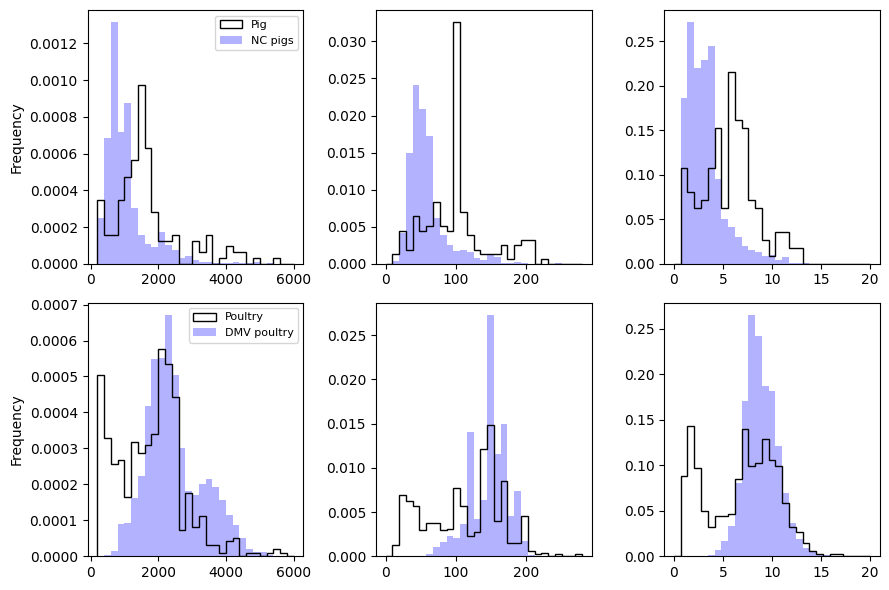

In [ ]:
# Plot histograms showing all farm types, not-farms, and DMV+NC data

bins = {}
bins['Area (sq m)'] = np.linspace(min_building_size, 6000, 30)
bins['Length (m)'] = np.linspace(0, 280, 30)
bins['Aspect ratio'] = np.linspace(0, 20, 30)

_, axes = plt.subplots(2, 3, figsize=(9, 6))
for farm_type, ax in zip(["Pig", "Poultry"], axes):
  print(f"{farm_type} farms \n")
  to_plot = max_farm_bldgs[max_farm_bldgs["Farm type"] == farm_type]
  explore.histos(to_plot, ax, bins, farm_type, dmv_data, nc_data)

plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/CAFO_data/Analysis/Chile_building_histos.png')

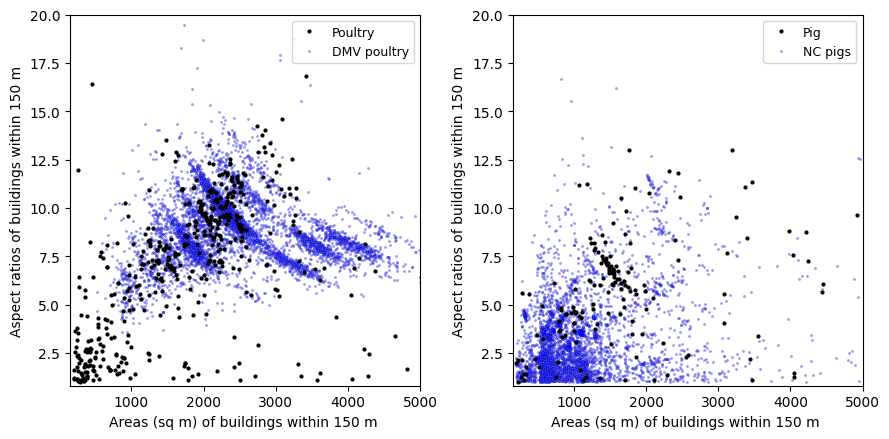

In [ ]:
# Plot aspect ratio vs area for all farm types and DMV+NC data

_, axes = plt.subplots(1, 2, figsize=(9, 4.5))

for ax, farm_type in zip(axes, ['Poultry', 'Pig']):

  # Plot Chile data
  to_plot = max_farm_bldgs[max_farm_bldgs["Farm type"] == farm_type]
  ax.plot(to_plot["Area (sq m)"], to_plot["Aspect ratio"], 'ko', ms=2,\
          label=farm_type)

  # Add comparison (DMV+NC) data
  if farm_type == "Poultry":
    ax.plot(dmv_data['Area (sq m)'], dmv_data['Aspect ratio'],\
               'bo', markerfacecolor=(1, 1, 0, 0.4), ms=1,\
               zorder=0, label="DMV poultry")
  if farm_type == "Pig":
    ax.plot(nc_data['Area (sq m)'], nc_data['Aspect ratio'],\
               'bo', markerfacecolor=(1, 1, 0, 0.4), ms=1,\
               zorder=0,  label="NC pigs")

  ax.legend(fontsize=9)
  ax.set_xlim(min_building_size-50, 5000)
  ax.set_ylim(0.8, 20)
  ax.set_xlabel(f'Areas (sq m) of buildings within {farm_dist} m ')
  ax.set_ylabel(f'Aspect ratios of buildings within {farm_dist} m')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Chile_aspect_area.png")

## Characteristics of farm buildings/animal housing: plots

There are clearly lots of small, squarish buildings in the Chile birds plots which either belong to farms that are smaller/non-industrial, or are not animal housing, or aren't farm buildings at all. However, there is also a tail of buildings with characteristics like those of DMV poultry barns. This is presumably the "industrial" population.

I'm less sure how to interpret pigs, but perhaps the pig farms are almost all industrial? There also appears to be a subset of large and narrow pig-associated buildings that isn't in the NC data. It's possible that that's contamination from nearby bird farms, maybe. But I think it's more likely that some pig barns in Chile are longer and narrower than in NC. I saw that in the Mexico dataset as well.

## Farm-associated buildings as a function of animal number

As we have animal numbers associated with the Chilean farms, we can also ask whether a transition to buildings with "standard, industrial" characteristics occurs at any particular number of animals. While the above plots showed the characteristics of all buildings (> 400 sq m) within 200 m of farm coordinates, here I use only the largest/longest/narrowest building, assuming that that is most likely to represent animal housing. The blue lines show the min, med, and max values from the DMV dataset (for birds) and the median value from the NC dataset (for pigs).

Below about 3000 birds, most of the buildings are small and around or below the minimum size in the DMV dataset. From there to about 10,000 birds, there is a mixture of building characteristics. At around 20,000-50,000 birds, there is a cluster with building characteristics very close to the median DMV values. Finally, above 100,000 birds, all buildings are large, long, and narrow (the few outliers turn out to be inaccurate coordinates). This is all a bit messy but I'd say that above a few thousand birds per farm, there is a good chance that you're going to be looking at an industrial facility.

The pig comparison data are a bit messy, but I'd say that farms with >1000 pigs will mostly be standard and industrial, and smaller farms might sometimes be as well.

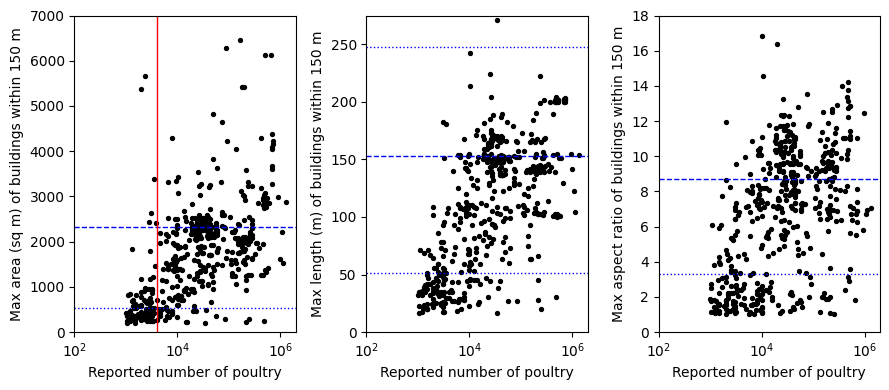

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(9, 4))
to_plot = max_farm_bldgs[max_farm_bldgs["Farm type"] == "Poultry"]
explore.building_scatterplots(to_plot, farm_dist, "Poultry", compare=dmv_data,\
                      fname="Chile_poultry_buildings", axes=axes)
axes[0].axvline(4000, color='r', lw=1)
plt.tight_layout()

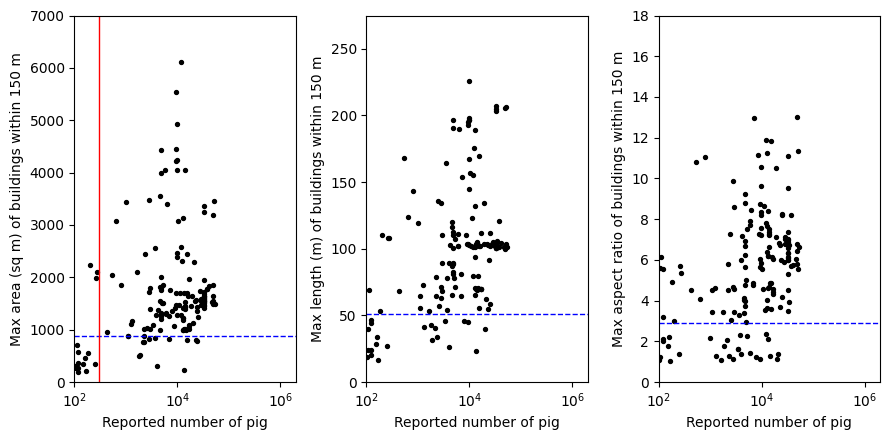

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(9, 4.5))
to_plot = max_farm_bldgs[max_farm_bldgs["Farm type"] == "Pig"]
explore.building_scatterplots(to_plot, farm_dist, "Pig", compare=nc_data,\
                              fname="Chile_pig_buildings", axes=axes)
axes[0].axvline(300, color='r', lw=1)
plt.tight_layout()

Use the following cell to find coords of farms with certain characteristics, and paste into Google Maps.

* $>$1e5 birds & building area < DMV minimum
  * Inaccurate coordinates (offset from farm buildings)
* < 5000 birds and building area > DMV median
  * Small, nonstandard, or possible CAFOs, but max building is a nearby non-CAFO building (often nursery/covered horticulture)
  * Two actual standard CAFO buildings on same farm, isolated, perhaps animal numbers underreported
  * An agricultural school
  * A real CAFO that is labelled as a pig breeder on gmaps



In [ ]:
temp = max_farm_bldgs[(max_farm_bldgs['Number of animals'] < 5000)]
temp = temp[temp['Farm type'].str.match('Poultry')]
temp = temp[temp['Area (sq m)'] > dmv_data['Area (sq m)'].median()]
lons = [p.centroid.x for p in temp['Parent coords']]
lats = [p.centroid.y for p in temp['Parent coords']]
for lat, lon in zip(lats, lons):
  print(lat, lon)

-35.01886053761494 -71.4265865288449
-32.84847129174538 -71.20033760192305
-34.333887136786394 -71.33581874044319
-33.6119101042341 -71.51647723134317
-33.61381724115649 -71.52332158128014
-35.85174743583649 -71.57964978834664
-33.89046830432816 -70.64820224773356


It's not necessarily a problem if the CAFO coordinates aren't very accurate (so the buildings aren't real farm buildings), as long as they're close enough that the final Sentinel data - which will be centered on the building coords - do capture the farm buildings themselves. In fact, it might be good if some of the CAFOs aren't centered in the images. So we won't do anything about large farms with small buildings.

However, we do want to remove small farms that it's probably not realistic to get the model to recognise. They will probably just contaminate the training data and make it more difficult to recognize the large CAFOs. With the Chile data we have the advantage that we have some info about animal numbers, so we can be clear that we are training the model to identify farms above a certain number of animals. So, we will restrict the farm df to those with >4000 poultry and >300 pigs. We will now do that and create the matching not-farm dataset.

In [ ]:
df1 = max_farm_bldgs[(max_farm_bldgs['Farm type'].str.match('Poultry'))\
                     & (max_farm_bldgs['Number of animals'] > 4000)]
df2 = max_farm_bldgs[(max_farm_bldgs['Farm type'].str.match('Pig'))\
                     & (max_farm_bldgs['Number of animals'] > 300)]

print(f"End up with {len(df1)} Poultry farms and {len(df2)} pig farms")

final_farm_bldgs = pd.concat([df1, df2])

End up with 406 Poultry farms and 146 pig farms


In [ ]:
# The not-farm sample will match the Area distribution of the combined pig and
# poultry df
sampled = explore.stratified_sample(final_farm_bldgs, other_buildings, 'Area (sq m)',\
                                 bins=bins['Area (sq m)'])

# Calculate length and aspect ratio for the not-farm buildings
notfarm_buildings = explore.get_dimensions(sampled, crs=crs)

# Sometimes there are a few aspect ratios that seem unrealistic, probably
# where the building footprint database has confused roads with buildings.
# Drop these.

notfarm_buildings = notfarm_buildings[notfarm_buildings['Aspect ratio'] < 20]

print(f"We have {len(notfarm_buildings)} not-farm buildings")

We have 540 not-farm buildings


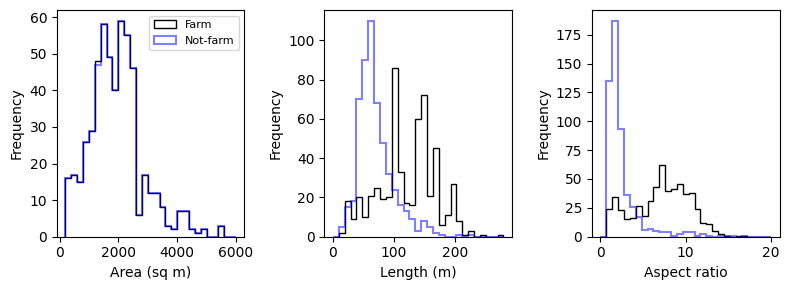

<Figure size 640x480 with 0 Axes>

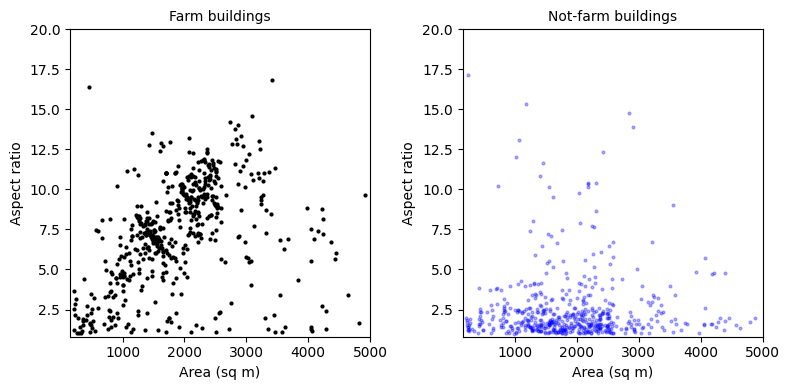

<Figure size 640x480 with 0 Axes>

In [ ]:
# Compare the distributions etc., using the usual plots

_ , axes = plt.subplots(1, 3, figsize=(8, 3))

for ax, col in zip(axes, ["Area (sq m)", "Length (m)", "Aspect ratio"]):
  ax.hist(final_farm_bldgs[col], bins=bins[col], histtype='step', color='k',\
          label="Farm")
  ax.hist(notfarm_buildings[col], bins=bins[col], histtype='step', color='b',\
          alpha=0.5, lw=1.5, label="Not-farm")
  if col == "Area (sq m)":
    ax.legend(fontsize=8)
  ax.set_ylabel("Frequency")
  ax.set_xlabel(col)
plt.tight_layout()
plt.show()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Chile_final_histos.png")

def axis_stuff(ax, label):
  ax.set_xlim(min_building_size-50, 5000)
  ax.set_ylim(0.8, 20)
  ax.set_xlabel(f'Area (sq m)')
  ax.set_ylabel(f'Aspect ratio')
  ax.set_title(label, fontsize=10)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.plot(final_farm_bldgs["Area (sq m)"], final_farm_bldgs["Aspect ratio"], 'ko', ms=2)
axis_stuff(ax1, "Farm buildings")
ax2.plot(notfarm_buildings["Area (sq m)"], notfarm_buildings["Aspect ratio"],\
        'bo', ms=2, alpha=0.3)
axis_stuff(ax2, "Not-farm buildings")
plt.tight_layout()
plt.show()
plt.savefig("/content/drive/MyDrive/CAFO_data/Analysis/Chile_final_aspect_area.png")

In [ ]:
# Create the final dataset that will be used for training. We'll reduce the size
# of the not-farm sample to decrease the data volume.

# -- Farm buildings
final_farm_bldgs.loc[:, "Dataset name"] = "Chile"
final_farm_bldgs = explore.re_order(final_farm_bldgs)
print(f"Saving {len(final_farm_bldgs)} farms")

# -- Not-farm buildings
coldict = {"Dataset name": "Chile", "Parent coords": None,\
           "Farm type": "Non-farm", "Number of animals": np.nan}
for col, val in coldict.items():
  notfarm_buildings.loc[:, col] = val

notfarm_buildings = explore.re_order(notfarm_buildings)
notfarm_sample = notfarm_buildings.sample(n=300)
print(f"Saving {len(notfarm_sample)} not-farms")

chl = pd.concat([final_farm_bldgs, notfarm_sample])
chl.to_pickle(f'/content/drive/MyDrive/CAFO_data/forTraining/interim_files/Chile_bldgs.pkl')

Saving 552 farms
Saving 300 not-farms
